In [1]:
import re
import matplotlib.pyplot as plt
import urllib
import json
import time
from sklearn.model_selection import train_test_split
from ast import literal_eval
import networkx as nx
from datetime import datetime
from networkx.algorithms.bipartite.projection import overlap_weighted_projected_graph
import random 
import transformers
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

%matplotlib inline

# Objective and General Approach

The objective is to build a recommendation system that allows to retrieve similar scientific papers given the title and abstract of another paper.

For this purpose, a bipartite document-topic graph is created where the topics of each document are obtained from an API (https://www.semanticscholar.org/product/api). Using this bipartite graph, it is possible to produce a document-level graph where an edge exists between two documents if they have at least one topic in common.

This last graph is used to mine triplets documents: an anchor document, a positive document and a negative document. The anchor and the positive example are two documents connected by an edge and the negative sample is either sampled randomly from the graph or is a document connected to the positive document but not the anchor document (hard negative).

The title and abstract of those triplets are then used in order to fine-tune a SciBERT model (https://arxiv.org/abs/1903.10676) using the triplet margin loss function in order to encode the relationship between documents into the representation. Using this representation, it is possible to retrieve similar scientific papers using the Euclidian distance as similarity function.


N.B.: The approach discussed above is similar to the approach used in the following paper: https://arxiv.org/abs/2004.07180

# Data Collection

The data collection consists into looking for the topics, abstract and authors of each papers through the API. The authors were initially provided by Radix (authors.csv); however, the field *source_id* is not unique. That means that it is impossible to link correctly each paper to the correct authors.

In [8]:
papers = pd.read_csv('Data/papers.csv')

In [9]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9680 entries, 0 to 9679
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source_id  9680 non-null   int64 
 1   year       9680 non-null   int64 
 2   title      9680 non-null   object
 3   abstract   6361 non-null   object
 4   full_text  9677 non-null   object
dtypes: int64(2), object(3)
memory usage: 378.2+ KB


In [10]:
# Clean the title of extra whitespace
papers['clean_title'] = papers['title'].apply(lambda x: re.sub("\s\s+", " ", x).title())
papers = papers[['year', 'clean_title', 'full_text']]

In [11]:
def callAPI(url):
    '''
    Call the API endpoint. If code 403, need to wait 5 minutes.
    '''
    
    print(url)
    url = url.encode('ascii', 'ignore').decode()
    while True:
        try:
            response = urllib.request.urlopen(url)
            return json.load(response)
        except urllib.error.HTTPError as e:
            
            if e.code == 403:
                print('sleeping')
                time.sleep(330)
            else:
                return []

In [12]:
def extractInfo(data):
    '''
    Extract the information about a paper from the API.
    Works in two steps: first search the paperID from the database, then collect the abstract, authors and topics.
    '''
    
    url_search = 'https://api.semanticscholar.org/graph/v1/paper/search?query='
    url_info = 'https://api.semanticscholar.org/v1/paper/'
    
    df = pd.DataFrame()
    
    for _, row in data.iterrows():
        query = row.clean_title.replace('"', '').replace(' ', '+').replace('\'', "").replace('`', "")

        search_results = callAPI(url_search+query)
        paperId = ''
        
        # Search the paperID from the results
        if search_results:
            for result in search_results['data']:
                title_found = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", result['title'])
                paper_title = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", row.clean_title)
                if title_found.lower() == paper_title.lower():
                    paperId = result['paperId']
            
            # If paperID found collect informations
            if paperId != '':
                data = callAPI(url_info+paperId)
                abstract = data['abstract']
                authors = [x['authorId'] for x in data['authors']]
                topics = [x['topic'] for x in data['topics']]
                info = pd.DataFrame({'clean_title': row.clean_title,
                                     'year': row.year,
                                     'abstract': abstract,
                                     'topics': [topics],
                                     'authors': [authors],
                                     'full_text': row.full_text})
            
                df = df.append(info, ignore_index=True)
    return df

In [ ]:
dataset = extractInfo(papers)

In [7]:
# Drop rows where information could not be retrieved
dataset.dropna(inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9308 entries, 0 to 9307
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clean_title  9308 non-null   object
 1   year         9308 non-null   int64 
 2   abstract     9308 non-null   object
 3   topics       9308 non-null   object
 4   authors      9308 non-null   object
 5   full_text    9308 non-null   object
 6   source_id    9308 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 581.8+ KB


In [6]:
number_topics = dataset.topics.apply(len)
topic_list = np.concatenate(dataset.topics.values)
print('On average {0:.2f} topics per paper'.format(np.mean(number_topics)))
print('{} unique topics'.format(len(np.unique(topic_list))))

On average 9.13 topics per paper
7093 unique topics


In [ ]:
# Replace the non-unique source_id by the index
dataset['source_id'] = dataset.index
dataset.to_csv('Data/clean_papers.csv', index=False)

# Graph Representation

Before creating the graph, the dataset is split into a train and a test set. The train set is used to create the bipartite graph by unfolding the topics, authors and year attributes of each paper. The test set is not used to generate the graph nor is it used to train the model, but will be solely used at the end to inspect the papers recommended by the system.

## Bipartite Graph Creation

In [ ]:
dataset = pd.read_csv('Data/clean_papers.csv', converters={'authors': literal_eval, 'topics': literal_eval})
dataset.drop(['full_text'], axis=1, inplace=True)

X_train, X_test = train_test_split(dataset, test_size=100, random_state=42)
X_train.to_csv('Data/train.csv', index=False)
X_test.to_csv('Data/test.csv', index=False)

edges = pd.DataFrame([
    {"source": row.source_id, "target": str(val), "type": _type}
    for _, row in X_train.iterrows()
    for _type in ["topics", "authors"]
    for (val) in row[_type]
])

edges = edges.append(pd.DataFrame([{"source": row.source_id, "target": row.year, "type": "year"}
    for _, row in X_train.iterrows()]))

edges = edges.replace(to_replace='None', value=np.nan)
edges = edges.replace(to_replace='null', value=np.nan)
edges.dropna(inplace=True)
edges.to_csv('Data/full_edges.csv', index = False)

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9208 entries, 0 to 9207
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clean_title  9208 non-null   object
 1   year         9208 non-null   int64 
 2   abstract     9208 non-null   object
 3   topics       9208 non-null   object
 4   authors      9208 non-null   object
 5   source_id    9208 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 431.8+ KB


In [15]:
edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121919 entries, 0 to 121918
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   source  121919 non-null  int64 
 1   target  121919 non-null  object
 2   type    121919 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [16]:
edges[edges.duplicated()]

source          target     type
24868     222         Synergy   topics
31873     418        Gradient   topics
32912    4245  Bioinformatics   topics
41156     916             Map   topics
69867    3315      Vocabulary   topics
85960    9185       120149052  authors

In [ ]:
# Graph creation from the edge list
G = nx.Graph()
for _, row in X_train.iterrows():
    G.add_node(row.source_id, _type = 'document', abstract = row.abstract, title = row.clean_title)
for _, row in edges.iterrows():
    if row.type == "authors" or row.type == "topics":
        G.add_node(str(row.target), _type = row.type)
        G.add_edge(row.source, row.target)
    else:
        year = datetime.strptime(str(row.target), '%Y')
        G.add_node(year, _type = row.type)
        G.add_edge(row.source, year)

In [17]:
# There are duplicated edges in the file due to an authorID and Topics present twice in the list retrieved by the API
G.number_of_edges()

121913

In [18]:
print(len({n for n, d in G.nodes(data=True) if d["_type"] == 'document'}))
print(len({n for n, d in G.nodes(data=True) if d["_type"] == 'year'}))
print(len({n for n, d in G.nodes(data=True) if d["_type"] == 'topics'}))
print(len({n for n, d in G.nodes(data=True) if d["_type"] == 'authors'}))

9208
33
7048
13641


In [ ]:
nx.write_gpickle(G, "Data/full_graph.gpickle")

## Bipartite Graph Analysis and Document-level Graph

The final document-level graph was obtained through an iterative process. In the end, the following modifications were implemented:

* Some topics are removed if their degree is below 3 and above 200.
* The authors and year attributes are removed as they did not seem to help produce pertinent edges in the document-level graph.
* In the document-level graph, edges with a weight inferior to 0.3 are removed. This weight is calculated using the Jaccard Index between the neighborhoods of two documents in the bipartite graph.
* Only documents with at least one neighbor are kept in the final document-level graph.

In [19]:
G = nx.read_gpickle("Data/full_graph.gpickle")

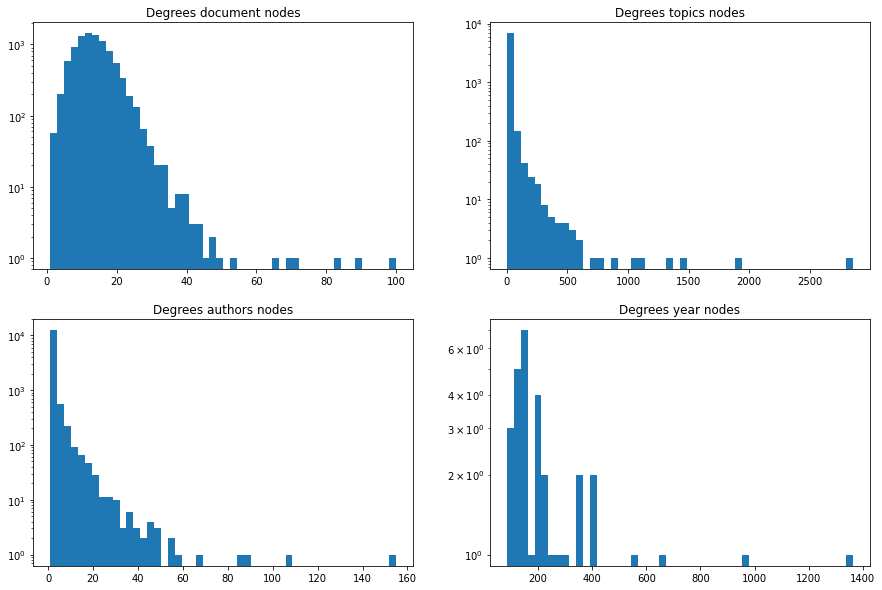

In [20]:
plt.figure(figsize=(15,10))
for i, _type in enumerate(['document', 'topics', 'authors', 'year']):
    plt.subplot(2, 2, i+1)
    nodes_type = {n for n, d in G.nodes(data=True) if d["_type"] == _type}
    degrees = pd.Series({k: v for k, v in nx.degree(G, nbunch=nodes_type)})
    plt.hist(degrees, log=True, bins=50)
    plt.title('Degrees {} nodes'.format(_type))

In [21]:
topics_nodes = {n for n, d in G.nodes(data=True) if d["_type"] == "topics"}
topics_degree_kept = {n for n, d in nx.degree(G, nbunch=topics_nodes) if d>=3 and d <= 200}
print('Original number of topic: {} Number of topic kept: {}'.format(len(topics_nodes),len(topics_degree_kept)))
print('Percentage retained: {0:.2f} %'.format( (len(topics_degree_kept)/len(topics_nodes))*100 ))
print('')
print(topics_degree_kept)

Original number of topic: 7048 Number of topic kept: 2816
Percentage retained: 39.95 %

{'Depth perception', 'Test scaling', 'Triangular function', 'Convex conjugate', 'Connectomics', 'Resampling (statistics)', 'Proximal gradient methods for learning', 'In-phase and quadrature components', 'Mobile robot', 'Stochastic control', 'Communication endpoint', 'Spatial organization', 'Independent component analysis', 'Interface Device Component', 'Feature learning', 'FLOPS', 'Local convergence', 'Bootstrapping (statistics)', 'Algorithmic learning theory', 'LEON', 'Binary data', 'Map (parallel pattern)', 'Mental Suffering', 'Itakura–Saito distance', 'K-means clustering', 'Ergodic theory', 'Viterbi algorithm', 'Cache-oblivious algorithm', 'StarCraft', 'Persistent data structure', 'Colors of noise', "Hilbert's tenth problem", 'Simplex algorithm', 'Anatomic Node', 'Neural Network Simulation', 'Choice Behavior', 'SQL Access Group', 'Newton', 'Fisher kernel', 'Algorithmic game theory', 'Geodesic con

In [22]:
# Removing the years, authors and filtered topics
topics_filtered = topics_nodes - topics_degree_kept
nodes_authors = {n for n, d in G.nodes(data=True) if d["_type"] == 'authors'}
nodes_years = {n for n, d in G.nodes(data=True) if d["_type"] == 'year'}
sub_graph = G.subgraph(set(G.nodes) - topics_filtered - nodes_years - nodes_authors)

In [23]:
document_graph = overlap_weighted_projected_graph(sub_graph, {n for n, d in sub_graph.nodes(data=True) if d["_type"] == 'document'})
print(document_graph.number_of_edges())
print(document_graph.number_of_nodes())

1365036
9208


In [24]:
nodes_degrees = pd.Series({k: v for k, v in nx.degree(document_graph)})
edges_weights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in document_graph.edges(data=True)})

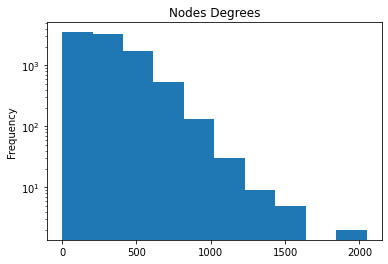

In [25]:
nodes_degrees.plot.hist()
plt.title('Nodes Degrees')
plt.yscale("log")

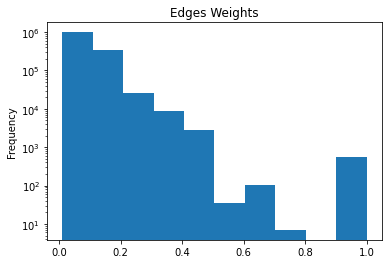

In [26]:
edges_weights.plot.hist()
plt.title('Edges Weights')
plt.yscale("log")

In [27]:
# Removing edges with a weight inferior to 0.3
filtered_document_graph = document_graph.copy()
edges_to_remove =  [edge for edge in filtered_document_graph.edges if filtered_document_graph.edges[edge]["weight"]<0.3]
filtered_document_graph.remove_edges_from(edges_to_remove)

In [28]:
filtered_document_graph.number_of_edges()

12560

average degree 2.728062554300608


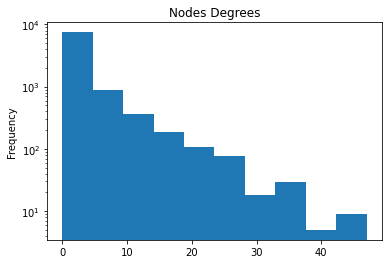

In [29]:
nodes_degrees = pd.Series({k: v for k, v in nx.degree(filtered_document_graph)})
print('average degree', np.mean(list(nodes_degrees)))
nodes_degrees.plot.hist()
plt.title('Nodes Degrees')
plt.yscale("log")

In [30]:
# Keeping only documents with at least one neighbour.
components = pd.Series({ith: component 
              for ith, component in enumerate(nx.connected_components(filtered_document_graph))})
core_document_graph = nx.subgraph(
    filtered_document_graph,
    [node for nodes in components[components.apply(len)>2].values for node in nodes])

In [31]:
core_document_graph.number_of_nodes()

4034

In [ ]:
nx.write_gpickle(core_document_graph, "Data/filtered_graph.gpickle")

# Triplet Mining

The final graph is traversed to mine for triplets using the following procedure:
* Each node in the graph is used as anchor and all of its neighbors are positive examples.
* For each pair anchor-positive example, 5 negative examples are mined.
* Those 5 negative exmaples are composed of 3 hard negatives and 2 easy negatives which are randomly sampled. If there are less than 3 hard negatives possible, those are replaced by easy negatives.

In [ ]:
G_filtered = nx.read_gpickle("Data/filtered_graph.gpickle")
G_full = nx.read_gpickle("Data/full_graph.gpickle")

In [ ]:
def tripletMining(G_filtered, G_full, n_hard_negative, n_total_triplet):
    '''
    Mine the triplet (anchors, positives, negatives) from the graph
    '''
    
    triplet = pd.DataFrame()
    neighbors = { node: [n for n in G_filtered.neighbors(node)] for node in G_filtered}
    all_nodes = {n for n, d in G_full.nodes(data=True) if d["_type"] == 'document'}
    for node, neighbors_list in neighbors.items():
        for neighbor in neighbors_list:
            
            # hard negatives mining
            hard_negatives = set(neighbors[neighbor]) - set(neighbors_list + [node])
            n_hard_sample = n_hard_negative if len(hard_negatives) >= n_hard_negative else len(hard_negatives)
            sampled_hard_negatives = random.sample(hard_negatives, n_hard_sample)
            
            for negative in sampled_hard_negatives:
                triplet_hard_negatives = pd.DataFrame.from_records([{'anchor': node,
                                                       'positive': neighbor,
                                                       'negative': negative}])
                triplet = triplet.append(triplet_hard_negatives, ignore_index=True)
                
            # random negatives mining 
            random_negatives = random.sample(all_nodes - set(neighbors[neighbor]) - set(neighbors_list), 
                                             n_total_triplet - n_hard_sample)
            
            for negative in random_negatives:
                triplet_random_negatives = pd.DataFrame.from_records([{'anchor': node,
                                                       'positive': neighbor,
                                                       'negative': negative}])
                triplet = triplet.append(triplet_random_negatives, ignore_index=True)

    return triplet

In [ ]:
triplet = tripletMining(G_filtered, G_full, 3, 5)
triplet.to_csv('Data/triplet.csv', index=False)

# Model

The model consists of a SciBERT model where the pooler and the last transformer layer are fine-tuned for 10 epochs using the triplet margin loss function with a margin equal to 1. After each epoch, the model weights are saved if the loss decreased for the validation set.

In [ ]:
triplets = pd.read_csv('Data/triplet.csv')
X_train, X_val = train_test_split(triplets, test_size=0.33, random_state=42)
data = pd.read_csv('Data/train.csv', converters = {'clean_title': str, 'abstract': str})

In [ ]:
class TripletDataset(Dataset):
    ''' 
    Dataset for fine-tuning the BERT model.
    '''
    def __init__(self, data , triplets, tokenizer, max_len):
        """Initialise the dataset."""
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.data = data
        self.triplets = triplets

        
    def encode(self, text):
        '''Encode the text using tokenizer.'''
        return self.tokenizer.encode_plus(text,add_special_tokens=True, max_length=self.max_len,
                                         return_token_type_ids=False, padding='max_length',
                                         return_attention_mask=True, return_tensors='pt',truncation = True)
        
    def __getitem__(self, index):
        '''Get a triplet from the dataset and encode the title and abstract.'''
        anchor, positive, negative = self.triplets.iloc[index]
        
        title_anchor = self.data[self.data['source_id'] == anchor]['clean_title'].item()
        title_positive = self.data[self.data['source_id'] == positive]['clean_title'].item()
        title_negative = self.data[self.data['source_id'] == negative]['clean_title'].item()
        
        abstract_anchor = self.data[self.data['source_id'] == anchor]['abstract'].item()
        abstract_positive = self.data[self.data['source_id'] == positive]['abstract'].item()
        abstract_negative = self.data[self.data['source_id'] == negative]['abstract'].item()
        
        encoding_anchor = self.encode(title_anchor + self.tokenizer.sep_token + abstract_anchor)
        encoding_postive = self.encode(title_positive + self.tokenizer.sep_token +abstract_positive)
        encoding_negative = self.encode(title_negative + self.tokenizer.sep_token + abstract_negative)
        
        return encoding_anchor, encoding_postive, encoding_negative
    
    def __len__(self):
        '''Dataset size.'''
        return len(self.triplets)

In [ ]:
class Tripletnet(nn.Module):
    '''Triplet BERT model.'''
    def __init__(self, model):
        '''Initialize the Triplet model using a specific BERT model.'''
        super(Tripletnet, self).__init__()
        self.bert = model

    def forward(self, anchor, positive, negative):
        '''Get the BERT representation for each triplet.'''
        embedded_anchor = self.bert(input_ids=torch.squeeze(anchor['input_ids']), 
                                     attention_mask=torch.squeeze(anchor['attention_mask'])).pooler_output
        embedded_positive = self.bert(input_ids=torch.squeeze(positive['input_ids']),
                                       attention_mask=torch.squeeze(positive['attention_mask'])).pooler_output
        embedded_negative = self.bert(input_ids=torch.squeeze(negative['input_ids']), 
                                       attention_mask=torch.squeeze(negative['attention_mask'])).pooler_output
        
        return embedded_anchor, embedded_positive, embedded_negative
                                                                                                        

In [ ]:
def moveTo(obj, device):
    '''Helper function to move the object to the correct device.'''
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        res = {}
        for k, v in obj.items():
            res[k] = moveTo(v, device)
        return res
    elif isinstance(obj, list):
        res = []
        for v in obj:
            res.append(moveTo(v, device))
        return res

In [ ]:
def trainModel(model, data_loader, loss_fn, optimizer, device, scheduler):
    '''Train the model.'''
    model.train()
    losses = []
    with tqdm(data_loader, unit="batch") as tepoch:
        for  anchor, positive, negative in tepoch:
            anchor = moveTo(anchor, device)
            positive = moveTo(positive, device)
            negative = moveTo(negative, device)

            embedded_anchor, embedded_positive, embedded_negative = model(anchor, positive, negative)

            loss = loss_fn(embedded_anchor, embedded_positive, embedded_negative)

            losses.append(loss.item())

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            tepoch.set_postfix(loss=loss.item())
        
    return np.mean(losses)

In [ ]:
def evalModel(model, data_loader, loss_fn, device):
    '''Evaluate the model.'''
    model.eval()
    losses = []
    with tqdm(data_loader, unit="batch") as tepoch:
        for anchor, positive, negative in tepoch:
            anchor = moveTo(anchor, device)
            positive = moveTo(positive, device)
            negative = moveTo(negative, device)
            embedded_anchor, embedded_positive, embedded_negative = model(anchor, positive, negative)

            loss = loss_fn(embedded_anchor, embedded_positive, embedded_negative)

            losses.append(loss.item())
            tepoch.set_postfix(loss=loss.item())
            
    return np.mean(losses)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 16
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


tokenizer = transformers.AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
bert = transformers.AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')


train_dataset = TripletDataset(data, X_train, tokenizer, 512)
val_dataset = TripletDataset(data, X_val, tokenizer, 512)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

# Freeze the layers except the pooler layer and last transformer layer
for param in bert.parameters():
    param.requires_grad = False
    
for name, param in bert.named_parameters():
    if any(layer in name for layer in ['pooler', '11']):
        param.requires_grad = True

model = Tripletnet(bert).to(device)

total_steps = len(train_loader) * EPOCHS
optimizer = transformers.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, correct_bias=False)
scheduler = transformers.get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                            num_training_steps=total_steps)

loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

In [ ]:
min_val_loss = np.inf

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_loss = trainModel(model, train_loader, loss_fn, optimizer, device, scheduler)

    print('Train loss {:.3f}'.format(train_loss))
    
    val_loss = evalModel(model, val_loader, loss_fn, device)
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.bert.state_dict(), 'Model/best_model_state.bin')

    print('Val loss {:.3f}'.format(val_loss))
    print()

# Inference

## Generate Embeddings

Before using the model for search, the embedding of each paper presents in the train set is generated. Then at inference, the model generates an embedding for the query title and abstract. This embedding is used to retrieve similar papers from the train set based on the Euclidean distance.

In [32]:
data = pd.read_csv('Data/train.csv', converters = {'clean_title': str, 'abstract': str})
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tokenizer = transformers.AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = transformers.AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
model.load_state_dict(torch.load('Model/best_model_state.bin', map_location=device))

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [33]:
@torch.no_grad()
def encodeText(title, abstract, model, tokenizer):
    '''Get the repsentation of the title and abstract using the fine-tuned model.'''
    model.eval()
    
    text = title + tokenizer.sep_token + abstract
    
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, max_length=512,
                                       return_token_type_ids=False, padding='max_length',
                                       return_attention_mask=True, return_tensors='pt',truncation = True)
    
    embedding = model(input_ids=inputs['input_ids'],
                     attention_mask=inputs['attention_mask']).pooler_output
    
    return np.array(embedding)

In [ ]:
# Generate embeddings for the train set
embeddings = data.apply(lambda x: encodeText(x['clean_title'], x['abstract'], model, tokenizer), axis = 1)
np.save('Data/embeddings.npy', embeddings)

## Search

In [34]:
test = pd.read_csv('Data/test.csv')
embeddings = np.load('Data/embeddings.npy', allow_pickle=True)

In [35]:
def searchNeighbors(query_title, query_abstract, k):
    '''Get the k most similar paper to the query based on the Euclidian distance.'''
    query_vector = encodeText(query_title, query_abstract, model, tokenizer)
    distances = np.linalg.norm(np.vstack(embeddings) - query_vector, axis = 1)
    neighbors = np.argpartition(distances, range(0, k))[:k]
    return neighbors

In [36]:
def recommendText(query_title, query_abstract, k):
    '''Search and print the k recommended papers.'''
    neighbors = searchNeighbors(query_title, query_abstract, k)
    print('Search Title: {}'.format(query_title))
    print('Search Abstract:')
    print(query_abstract)
    print('')
    print('Search Results:')
    for i in neighbors:
        print(data.iloc[i]['clean_title'])
        print(data.iloc[i]['abstract'])
        print('')

In [37]:
recommendText(test.iloc[5]['clean_title'], test.iloc[5]['abstract'], 5)

Search Title: Learning Sparse Perceptrons
Search Abstract:
We introduce a new algorithm designed to learn sparse perceptrons over input representations which include high-order features. Our algorithm, which is based on a hypothesis-boosting method, is able to PAC-learn a relatively natural class of target concepts. Moreover, the algorithm appears to work well in practice: on a set of three problem domains, the algorithm produces classifiers that utilize small numbers of features yet exhibit good generalization performance. Perhaps most importantly, our algorithm generates concept descriptions that are easy for humans to understand.

Search Results:
A Multi-Class Linear Learning Algorithm Related To Winnow
In this paper, we present Committee, a new multi-class learning algorithm related to the Winnow family of algorithms. Committee is an algorithm for combining the predictions of a set of sub-experts in the online mistake-bounded model of learning. A sub-expert is a special type of att

## Possible Improvement

The weights of the edges between documents give information about the strenght of the relationship between two documents, but are not use when training the current model.

One way to incorporate those weights during the training would be to use them in combination with the triplet margin loss function. This would be done weighting the loss function with the weight of the edge. A higher weight means that there is a stronger relationship and thus should impact the loss more.
